# Show or No Show? Visualization and Prediction
A beginner's attempt at using logistic regression to determine whether or not a patient is going to show up to an appointment.

## Questions to Consider
- What kinds of patients are we working with?
- Depending on a patient's characteristics, will he or she show up or not?
- What factors correlate the most to whether or not a patient shows up?
- If it's possible to accurately predict who the no-shows are to an appointment, what incentives can we offer these people to encourage them to show up to appointments?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('Set2')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data = pd.read_csv('../input/No-show-Issue-Comma-300k.csv')

# Preview the Data
Let's see what we're working with.

- 300k entries
- Features: age, gender, appointment registration and appointment date, day of week, show-up or no-show status, diabetes, alcoholism, hypertension, handicap, smokes, scholarship, tuberculosis, sms_reminder, awaiting time (number of days since the appointment was made)
- There are some spelling mistakes in the columns, so we can fix that up if we like.
- The exact dates (appointment registration and appointment date) are not as helpful as the awaiting time, which we already have, so we can consider dropping them from the dataset.
- There is at least one entry with a negative age, so we should also clean that later.

In [2]:
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
Age                        300000 non-null int64
Gender                     300000 non-null object
AppointmentRegistration    300000 non-null object
ApointmentData             300000 non-null object
DayOfTheWeek               300000 non-null object
Status                     300000 non-null object
Diabetes                   300000 non-null int64
Alcoolism                  300000 non-null int64
HiperTension               300000 non-null int64
Handcap                    300000 non-null int64
Smokes                     300000 non-null int64
Scholarship                300000 non-null int64
Tuberculosis               300000 non-null int64
Sms_Reminder               300000 non-null int64
AwaitingTime               300000 non-null int64
dtypes: int64(10), object(5)
memory usage: 34.3+ MB


In [4]:
data.describe()

,Age,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,37.808017,0.077967,0.025010,0.215890,0.020523,0.052370,0.096897,0.000450,0.574173,-13.841813
std,22.809014,0.268120,0.156156,0.411439,0.155934,0.222772,0.295818,0.021208,0.499826,15.687697
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-398.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-20.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-8.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.000000
max,113.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,2.000000,-1.000000


In [5]:
# fix spelling mistakes before proceeding
data.rename(columns={'Alcoolism': 'Alcoholism',
                    'HiperTension': 'Hypertension',
                    'Handcap': 'Handicap'}, inplace=True)
# data.columns

# Data Visualization
It's easier to see what we're working with if we visualize it using graphs rather than just looking at the numbers.

## Age and Gender

- The majority of the patients are less than ~60 years old. The largest age group is in the 50s.
- ~70% of the patients showed up and ~30% did not.
- ~67% of the patients were female and the remaining were male.
- Of the males who signed up for an appointment, ~45% did not show up to the appointment.
- Of the females who signed up for an appointment, ~43% did not show up to the appointment. 
- It is difficult to tell whether gender plays enough of a role in whether a patient shows up or not, but it appears that males are slightly more likely to be no-shows.

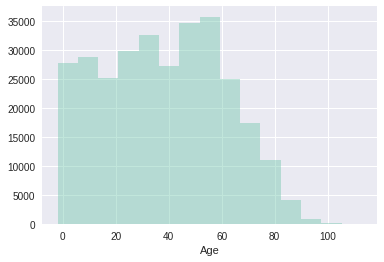

In [6]:
# graph distribution of age
g = sns.distplot(data['Age'], kde=False, bins=15)
plt.show()

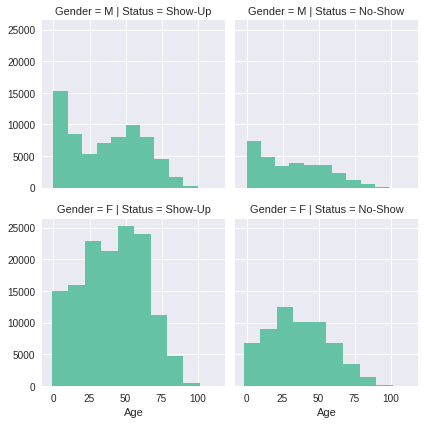

In [7]:
# graph distribution of genders and status
g = sns.FacetGrid(data, col='Status', row='Gender')
g.map(plt.hist, 'Age')
plt.show()

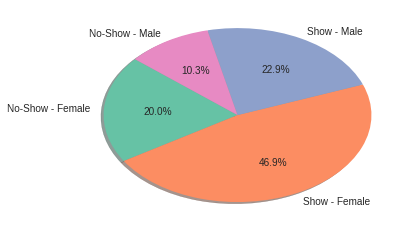

In [8]:
# pie chart of the no-shows and shows for both genders
labels = ['No-Show - Female', 'Show - Female', 'Show - Male', 'No-Show - Male']
sizes = [len(data[(data['Status'] == 'No-Show') & (data['Gender'] == 'F')]),
         len(data[(data['Status'] == 'Show-Up') & (data['Gender'] == 'F')]),        
         len(data[(data['Status'] == 'Show-Up') & (data['Gender'] == 'M')]),
         len(data[(data['Status'] == 'No-Show') & (data['Gender'] == 'M')])]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

## Days of the Week, Awaiting Times, and SMS Reminders
- Most of the appointments are made on weekdays and not on weekends. The most popular appointment days are in the middle of the week (Wednesday, Tuesday, and Thursday). Mondays and Fridays are the least popular days for appointments.
- Most of the patients waited less than 50 days for their schedule appointment.
- As expected, patients who receive a SMS reminder are more likely to show up for their appointment.
- Looking at the strip plot, it appears that SMS reminders are effective if appointments are more than 150 days away.

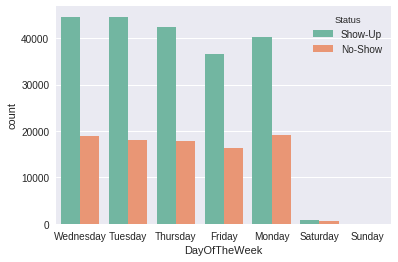

In [9]:
# graph distribution of patients for each day of the week
g = sns.countplot(x='DayOfTheWeek', hue='Status', data=data)
plt.show()

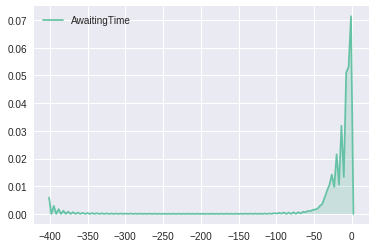

In [10]:
# graph distribution of awaiting times
g = sns.kdeplot(data['AwaitingTime'], shade=True)
plt.show()

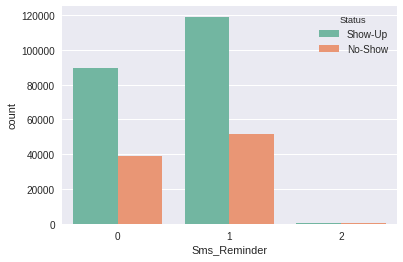

In [11]:
# graph distribution of sms reminders
g = sns.countplot(x='Sms_Reminder', hue='Status', data=data)
plt.show()

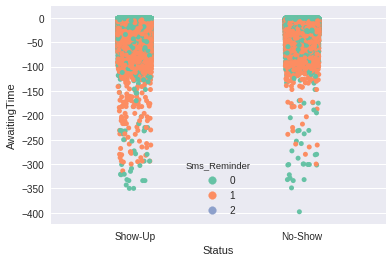

In [12]:
g = sns.stripplot(x='Status', y='AwaitingTime', data=data, 
                  hue='Sms_Reminder', jitter=True)
plt.show()

## Scholarship
Scholarship refers to money that is granted to those who may not be able to afford going to the doctor. It also emphasizes the importance of health and encourages people to go to the doctor when they need to.

- ~30,000 patients have scholarships.
- Although there are fewer people who have scholarships, it appears that people who have scholarships are more likely to not show up to appointments than people who don't have scholarships.

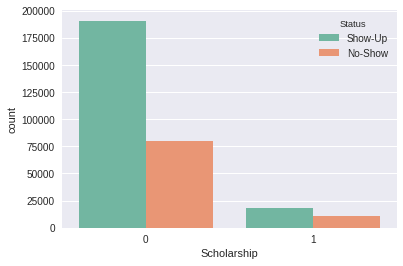

In [13]:
g = sns.countplot(x='Scholarship', hue='Status', data=data)
plt.show()

## Medical Conditions
Instead of visualizing all of the different medical conditions, I decided to sum them up and store the result in a new column.

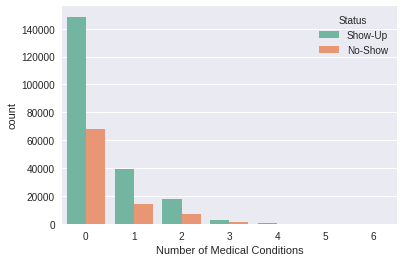

In [14]:
# add a column to count the number of medical conditions each patient has
sum = data['Diabetes'] + data['Alcoholism'] + data['Hypertension'] + \
    data['Handicap'] + data['Smokes'] + data['Tuberculosis']
data['Number of Medical Conditions'] = sum
# data.head(50)

g = sns.countplot(x='Number of Medical Conditions', hue='Status', data=data)
plt.legend(loc='upper right', title='Status')
plt.show()

# Cleaning Data
- There are 6 people with a negative age, and their real ages are uncertain. Instead of dropping these entries, we can just change their ages to the average age of all of the people in the dataset.
- Looking at the data, we probably don't care about the date of the appointment or the date when the patient registered for the appointment (AppointmentRegistration and ApointmentData).
- We also need to convert the non-numerical columns to numerics before applying machine learning algorithms.
- There are no null values, so we don't have to worry about that.

In [15]:
# data.describe()
data.loc[data['Age'] < 0, 'Age'] = 38
# data.describe()

In [16]:
# drop the specific dates and times
data.drop(['AppointmentRegistration', 'ApointmentData'], inplace=True, axis=1)
# data.head()

In [17]:
# convert the non-numeric columns to numerics
genderMap = {'M': 0, 'F':1}
dayMap = {'Sunday': 0,
         'Monday': 1,
         'Tuesday': 2,
         'Wednesday': 3,
         'Thursday': 4, 
         'Friday': 5,
         'Saturday': 6}
statusMap = {'No-Show':0, 'Show-Up': 1}
data = data.replace({'Gender': genderMap,
                    'DayOfTheWeek': dayMap,
                    'Status': statusMap})
data.head()

,Age,Gender,DayOfTheWeek,Status,Diabetes,Alcoholism,Hypertension,Handicap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime,Number of Medical Conditions
0,19,0,3,1,0,0,0,0,0,0,0,0,-29,0
1,24,1,3,1,0,0,0,0,0,0,0,0,-1,0
2,4,1,2,1,0,0,0,0,0,0,0,0,-1,0
3,5,0,4,1,0,0,0,0,0,0,0,1,-15,0
4,38,0,2,1,0,0,0,0,0,0,0,1,-6,0


# Modeling and Prediction
I pseudo-randomly split the dataset into two such that the training set has 60% of the data and the testing set has 40% of the data.

## Logistic Regression
Then, I used sklearn's logistic regression function to train and attempt to predict the Status of the testing data. There is approximately 70% accuracy, but looking at how the model correlates the features and the Status is interesting.

- Sms_Reminder is the largest, positive coefficient. This implies that if people received a SMS reminder for the appointment, they are more likely to show up to the appointment. This is to be expected.

- Alcoholism is the largest, negative coefficient. This implies that if someone has alcoholism, he/she is less likely to show up for the appointment. A similar statement can be said about patients who smoke.

- As seen before while visualizing the data, patients who have scholarships are less likely to show up for their appointments as well, according to the model.

In [18]:
# separate the independent variables from the result, Status
# also remove Number of Medical Conditions since it is dependent on other variables
X = data.drop(['Status', 'Number of Medical Conditions'], axis=1)
y = data['Status']

# split the set into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

69.700000000000003

In [19]:
# get correlations for each feature
coeff_df = pd.DataFrame(data.columns.delete(3))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
10,Sms_Reminder,0.102464
5,Hypertension,0.051191
6,Handicap,0.019088
2,DayOfTheWeek,0.013532
11,AwaitingTime,0.009975
0,Age,0.009349
1,Gender,0.000113
3,Diabetes,-0.024501
9,Tuberculosis,-0.024986
8,Scholarship,-0.211431


# Conclusion
 - This model can predict whether or not patients are going to show up to their appointments with a 70% accuracy by using the above features.
 - To encourage people to commit to their appointments, clinics should send them SMS reminders or some other form of reminder. Some people have busy lives and may have forgotten about their appointments, especially if they made the appointments months in advance.
 - There must be some reason why alcoholics and smokers are less likely to commit to their appointment dates. It may be because they are worried about asking for help or being judged and looked down upon. To encourage them to attend their appointments, clinics/hospitals can openly offer help and treatment for both physical and mental health. If patients are worried about being negatively judged, clinics/hospitals should consider options where patients can ask for help anonymously, at least in the beginning.
 - I found it surprising that people with scholarships were less likely to show up to their appointments. This may be because these patients don't have to pay for their appointments, so they are not as invested as people who have to pay to see the doctor. However, that isn't to say that these people shouldn't receive scholarships at all since it is still necessary for those who can't afford it. Nonetheless, we should consider how to get patients with scholarships to make the most of their scholarships by showing up to the appointments they signed up for.